# Customer Segmentation Notebook

In this notebook we will address the 'problem' of or opportunity to develop a targeted marketing strategy for the customers of a particular store.

To facilitate this, we will perform a customer segmentation analysis in which we identify 'hidden' clusters or groups of customers within one amalgamated dataset. Customer segmentation is important to businesses as it uses data to identify groups within their customer base that share key characteristics (e.g. behavioural or demographic). Identifying these groups, and understanding what factors contribute to group membership, can facilitate business initiatives such as targeted marketing, new sales strategies, specialized offers, and more. 

The data in this notebook come from [this kaggle dataset](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis) on Customer Personality Analysis. 

### In this notebook we will do the following:

- Import, Inspect, and Clean the Data
    + Check dimensions & data types
    + Check for and handle missing values
    + Visualize, identify, and handle outliers
- Feature Engineering
    + Customer Age
    + Household Occupancy
    + Customer History Length
    + Offer Campaign Acceptance
- Data Preprocessing
    + Categorical feature encoding
    + Continuous feature scaling
- Dimension Reduction
    + Principal component analysis
- Clustering
    + Determine optimal number of clusters
    + Execute clustering
    + Visualize cluster characteristics 
- Profiling
    + Examine demographic associations with spending habits
- Wrap-Up & Conclusions   


## Importing Libraries

In [108]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics


## Importing, Inspecting, & Cleaning Data

In [109]:
dat = pd.read_csv('marketing_campaign.csv', sep='\t') # tab-separated values
print(dat.shape)
dat.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


We have 2240 observations of 29 features in this customer dataset. Let's look at the info of the dataset. We'll look at the non-null counts (we'd like to see as many `2240` values as possible there) as well as the datatypes

In [110]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

So we have some missing values in `Income`, but only a handful. Our `Dt_Customer` is being considered an `object` as opposed to a `DateTime`, so we'll want to change that. 

In [111]:
dat = dat.dropna()
print(dat.shape)

(2216, 29)


Dropping all rows with `NA` in them brings us down to the same number of non-null rows in the `Income` feature from the original dataset, which is expected behaviour. That all looks good. 

Now let's fix the `Dt_Customer` data type.

In [112]:
dat['Dt_Customer'] = pd.to_datetime(dat['Dt_Customer'], format='%d-%M-%Y')
print(f'The newest customer enrollment is {dat["Dt_Customer"].max().date()}')
print(f'The oldest customer enrollment is {dat["Dt_Customer"].min().date()}')

The newest customer enrollment is 2014-01-31
The oldest customer enrollment is 2012-01-01


We'll use this fixed DateTime feature to engineer a couple new features a little later in the notebook. 

For now, let's start unpacking some of the categorical features and see what we have going on:

In [113]:
print(f'Total categories in the Marital Status feature: \n {dat["Marital_Status"].value_counts()} \n')
print(f'Total observations in dataset: {dat.shape[0]}')

Total categories in the Marital Status feature: 
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total observations in dataset: 2216


To my eye we have five main categories: `Married`, `Together` (in a relationship but not married), `Single`, `Divorced`, and `Widow`. The other categories (`Alone`, `Absurd`, and `YOLO`) have much lower membership. I think we can safely lump the `Alone` observations into `Single`, and trim out `Absurd` and `YOLO` as those are not informative categories. Expected behaviour is for this to remove 4 rows from the dataset, and have the `Single` category increase by 3 observations.

In [114]:
dat['Marital_Status'] = dat['Marital_Status'].replace('Alone', 'Single')
dat = dat[~dat['Marital_Status'].isin(['Absurd', 'YOLO'])]
print(f'Total categories in the Marital Status feature: \n {dat["Marital_Status"].value_counts()} \n')
print(f'Total observations in dataset: {dat.shape[0]}')


Total categories in the Marital Status feature: 
 Marital_Status
Married     857
Together    573
Single      474
Divorced    232
Widow        76
Name: count, dtype: int64 

Total observations in dataset: 2212


That all looks good, let's move on to our next categorical feature, `Education`. 

In [115]:
print(f'Total categories in the Education feature: \n {dat["Education"].value_counts()} \n')
print(f'Total observations in dataset: {dat.shape[0]}')

Total categories in the Education feature: 
 Education
Graduation    1115
PhD            479
Master         364
2n Cycle       200
Basic           54
Name: count, dtype: int64 

Total observations in dataset: 2212


This feature looks good, all of the educational categories are informative and well-populated

Now we will want to inspect our data for outliers. Let's print out a table of our numeric features, and then visualize their distributions

In [116]:
dat.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212,2212.000000,2212.000000,2212.000000,2212.000000,...,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.0,2212.0,2212.000000
mean,5587.731917,1968.811031,52232.510850,0.442586,0.505425,2013-01-26 03:53:39.547920384,49.050633,305.030741,26.324593,166.970163,...,5.320072,0.073689,0.074141,0.072785,0.063743,0.013562,0.009494,3.0,11.0,0.149638
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,2012-01-01 00:08:00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2814.750000,1959.000000,35233.500000,0.000000,0.000000,2013-01-02 00:08:00,24.000000,23.750000,1.750000,16.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,2013-01-16 00:09:00,49.000000,173.500000,8.000000,68.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8421.750000,1977.000000,68522.000000,1.000000,1.000000,2013-01-31 00:12:00,74.000000,505.500000,33.000000,232.250000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,2014-01-31 00:05:00,99.000000,1493.000000,199.000000,1725.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000
std,3247.944128,11.982065,25187.455359,0.537052,0.544258,NaN,28.940794,337.611255,39.781794,224.344950,...,2.423445,0.261323,0.262060,0.259842,0.244350,0.115691,0.096994,0.0,0.0,0.356797


We have a customer who was born in 1893, which may be a typo! That would make them roughly 130 years old at the time of this exercise. We also have someone making over $600,000 per year, leading to a very high standard deviation in our `Income` feature. 

Let's visualize the data in the `Year_Birth` and `Income` features to determine whether these are outliers:

Text(0.5, 1.0, 'Birth Year Distribution of Customer Dataset')

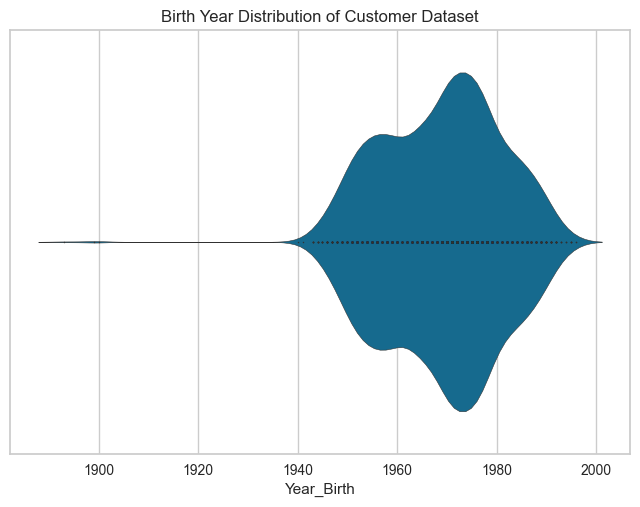

In [117]:
# Birth Year Plot
sns.violinplot(data=dat, x='Year_Birth', inner='point')
plt.title('Birth Year Distribution of Customer Dataset')


Text(0.5, 1.0, 'Income Distribution of Customer Dataset')

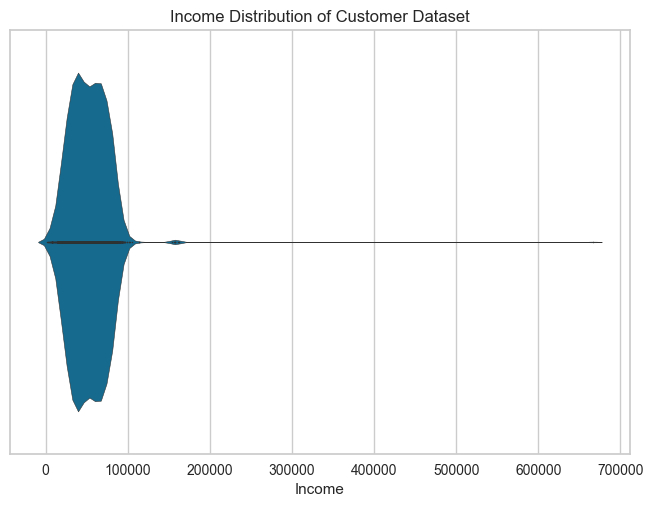

In [118]:
# Income plot
sns.violinplot(data=dat, x='Income', inner='point')
plt.title('Income Distribution of Customer Dataset')

Based on these plots we would indeed say that there are some outliers. Let's filter `Year_Birth` to be after 1940, and `Income` to be less than 600,000, then remake the plots:

Text(0.5, 1.0, 'Birth Year Distribution of Customer Dataset\n After Outlier Removal')

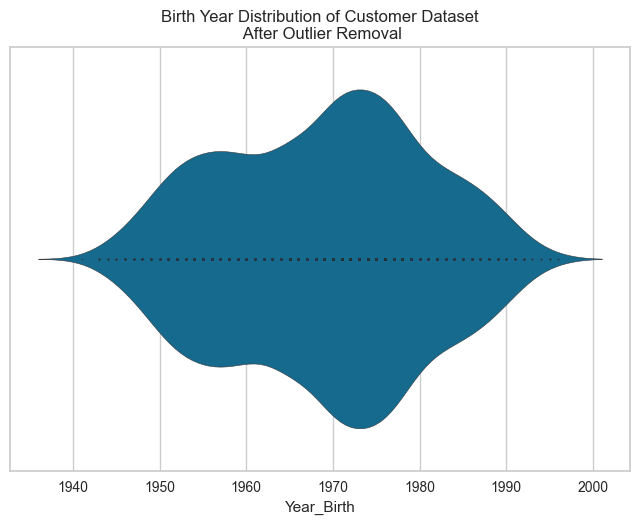

In [119]:
# Filter outliers based on Income and Year_Birth
dat = dat[(dat['Income'] < 600000) & (dat['Year_Birth'] > 1940)]

# Birth Year Plot
sns.violinplot(data=dat, x='Year_Birth', inner='point')
plt.title('Birth Year Distribution of Customer Dataset\n After Outlier Removal')

Text(0.5, 1.0, 'Income Distribution of Customer Dataset \n After Outlier Removal')

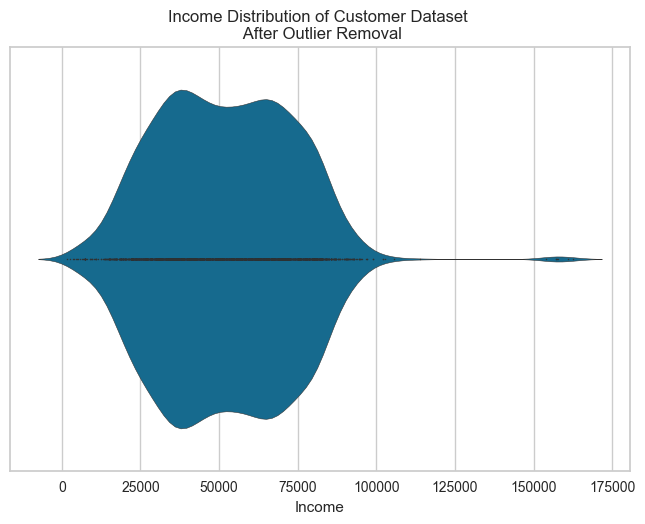

In [120]:
# Income plot
sns.violinplot(data=dat, x='Income', inner='point')
plt.title('Income Distribution of Customer Dataset \n After Outlier Removal')

The `Birth_Year` distribution looks great. While there's still a small high-income blip in the `Income` distribution, it's not to the same extreme degree of the outlier removed. It's possible that those high-income customers would have different behavioural habits so we'll keep those in the dataset.

Let's move on to engineering some new features from our cleaned-up data.

## Feature Engineering

We will use our data to generate some new features to use in the cluster/segmentation analysis. We have data on household occupancy through features like `Marital_Status`, `Kidhome`, and `Teenhome`. We can also infer how old someone is using their `Year_Birth`, and how long they have been a customer using their `Dt_Customer` data. We can also aggregate all of the categorized purchases into one `Spend` feature. Similarly, I'll aggregate all of the data on whether the customer accepted any campaign offers.

### Household Occupancy

In [121]:
dat['Children'] = dat['Kidhome'] + dat['Teenhome'] # add number of kids and number of teens in the household
dat['Adults'] = np.where(dat['Marital_Status'].isin(['Married', 'Together']), 2, 1) # add number of adults inferred through relationship status
dat['Household_Occupancy'] = dat['Children'] + dat['Adults'] # add number of children and adults in the household to get total occupancy
dat['Has_Children'] = np.where(dat['Children'] > 0, 1, 0) # binary feature for whether the household has children or not

# Checking our work:
occupancy_features = ['Kidhome', 'Teenhome', 'Children', 'Marital_Status', 
                      'Adults', 'Household_Occupancy', 'Has_Children']
print(dat[occupancy_features].head(10))
del(occupancy_features) # keep the object space clean

   Kidhome  Teenhome  Children Marital_Status  Adults  Household_Occupancy  \
0        0         0         0         Single       1                    1   
1        1         1         2         Single       1                    3   
2        0         0         0       Together       2                    2   
3        1         0         1       Together       2                    3   
4        1         0         1        Married       2                    3   
5        0         1         1       Together       2                    3   
6        0         1         1       Divorced       1                    2   
7        1         0         1        Married       2                    3   
8        1         0         1       Together       2                    3   
9        1         1         2       Together       2                    4   

   Has_Children  
0             0  
1             1  
2             0  
3             1  
4             1  
5             1  
6             1

### Age & Customer History Length

We will compute both an age for each customer as well as the length of time they have been registered as a customer. 

I'm going to have our time cutoff be the last registered customer, as opposed to today's date. The reason for this is that if we allow today's date to be the cutoff we'll be over-estimating peoples' ages relative to their actual purchasing events & patterns

In [122]:
# Customer Age
dat['Customer_Age'] = dat['Dt_Customer'].max().year - dat['Year_Birth']

# Customer History Length
dat['Customer_Length_Weeks'] = (dat['Dt_Customer'].max() - dat['Dt_Customer']).dt.days / 7 # convert to weeks (float)

### Total Spend

We will aggregate all the spend amounts from the separate spend categories to generate one overall spend variable. As mentioned before I will use this feature in addition to the other features, to permit the differentiation between two people with a similar total spend but potentially different spending allocations

In [123]:
spend_categories = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                    'MntSweetProducts', 'MntGoldProds']
dat['Total_Spend'] = dat[spend_categories].sum(axis=1) # total spend across all categories
spend_categories.append('Total_Spend') # add the new column to the list of spend categories
print(dat[spend_categories].head(10)) # check our work
del(spend_categories) # keep the object space clean

   MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0       635         88              546              172                88   
1        11          1                6                2                 1   
2       426         49              127              111                21   
3        11          4               20               10                 3   
4       173         43              118               46                27   
5       520         42               98                0                42   
6       235         65              164               50                49   
7        76         10               56                3                 1   
8        14          0               24                3                 3   
9        28          0                6                1                 1   

   MntGoldProds  Total_Spend  
0            88         1617  
1             6           27  
2            42          776  
3             5  

### Campaign Offer Acceptance

A total of 5 campaign offers were accepted. We'll aggregate whether the customer accepted each one (0 or 1 for each of 5 campaign columns) into one single column, for an integer representing the number of campaign offers each customer utilized.

In [124]:
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
dat['Offers_Accepted'] = dat[campaigns].sum(axis=1) # total number of campaigns accepted
print(dat['Offers_Accepted'].head(20)) # check our work
del(campaigns) # keep the object space clean

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     1
11    0
12    0
13    0
14    0
15    2
16    0
17    0
18    1
19    0
20    0
Name: Offers_Accepted, dtype: int64


Looks like not many customers utilize the offer campaigns. This in and of itself is useful information! Perhaps the offers were not marketed very thoroughly, or were not attractive enough to customers.

Now that we have engineered these new features, let's move on to preprocessing our data

## Data Preprocessing

We have a number of categorical features we'll need to encode, and many numerical features we'll need to scale.

First, we should identify which features we are *not* interested in carrying into this analysis. For example, `ID` is just a unique integer tag for each customer and would not be a useful metric to try to track customer behaviour with. Now that we have `Customer_Age`, we can probably do away with `Birth_Year`. We will also just keep `Offers_Accepted` in lieu of the 5 campaign columns. We'll also do away with `Response`, as it only talks about whether the customer accepted the last campaign and the overall campaign acceptance seems pretty sparse.

In [125]:
features_of_interest = ['Education', 'Marital_Status', 'Income', 'MntWines', 'MntFruits', 
                        'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                        'Total_Spend', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
                        'NumStorePurchases', 'NumWebVisitsMonth','Offers_Accepted',  'Customer_Age', 
                        'Has_Children', 'Household_Occupancy', 'Customer_Length_Weeks' ] # features of interest for PCA

dat_modeling = dat[features_of_interest] # create a new dataframe with only the features of interest
dat_modeling.head(10)
del(features_of_interest)

Now that we have our features of interest we can begin preprocessing. We'll use `ColumnTransformer` from `sklearn.compose`, and `StandardScaler` and `OneHotEncoder` from `sklearn.preprocesing`. 

We will generate a list of our categorical features, then a list of our numeric features, then pass that through the appropriate preprocessing steps.

In [126]:
# Get numeric features
numeric_features = dat_modeling.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get categorical columns
categorical_features = dat_modeling.select_dtypes(include=['object']).columns.tolist()


In [127]:
# Building the transformer
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ]
)

# Fit and transform the data
dat_preprocessed = preprocessor.fit_transform(dat_modeling)

# current object is a numpy array with no column names, we want to convert it
#       to a pandas DataFrame with proper column names   

# get column names from transformer for the OHE columns:
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine with numeric feature names
all_feature_names = numeric_features + list(ohe_feature_names)

# Convert numpy array to dataframe, using proper column names:
dat_preprocessed = pd.DataFrame(dat_preprocessed, columns = all_feature_names) # convert to DataFrame for easier handling
print(dat_preprocessed.head(10)) # Should see scaled values and one-hot encoded categories
del(ohe_feature_names,
    all_feature_names,
    categorical_features,
    numeric_features)

     Income  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  0.287607  0.976630   1.552817         1.689432         2.463799   
1 -0.260015 -0.871769  -0.637083        -0.718161        -0.651320   
2  0.913282  0.357535   0.571138        -0.178682         1.346021   
3 -1.174638 -0.871769  -0.561569        -0.655742        -0.504726   
4  0.294804 -0.391896   0.420110        -0.218808         0.154946   
5  0.490748  0.635980   0.394939        -0.307978        -0.687968   
6  0.171387 -0.208241   0.973878        -0.013717         0.228243   
7 -0.858527 -0.679227  -0.410541        -0.495236        -0.632995   
8 -1.002606 -0.862882  -0.662254        -0.637908        -0.632995   
9 -2.149623 -0.821412  -0.662254        -0.718161        -0.669644   

   MntSweetProducts  MntGoldProds  Total_Spend  NumDealsPurchases  \
0          1.482032      0.858129     1.675614           0.351820   
1         -0.634374     -0.733866    -0.962515          -0.167904   
2         -0.147844   

Excellent, our data are encoded and scaled. Time to start dimension reduction, which we will do through PCA.

## Dimension Reduction - Principal Component Analysis

PCA is a common dimension reduction technique that will reduce our features into orthogonal linear partitions of variance. AKA, things that are correlated (either positively or negatively) will get squished together into separate linear projections. 

We will make an elbow plot to determine how many principal components we can reasonably derive from the dataset. People like to stick to 3 principal components because that typically covers a decent amount of variance and can still be visualized in ways that are intuitive (X-Y-Z scatterplot), but if our elbow plot suggests we should use more we can look into that.

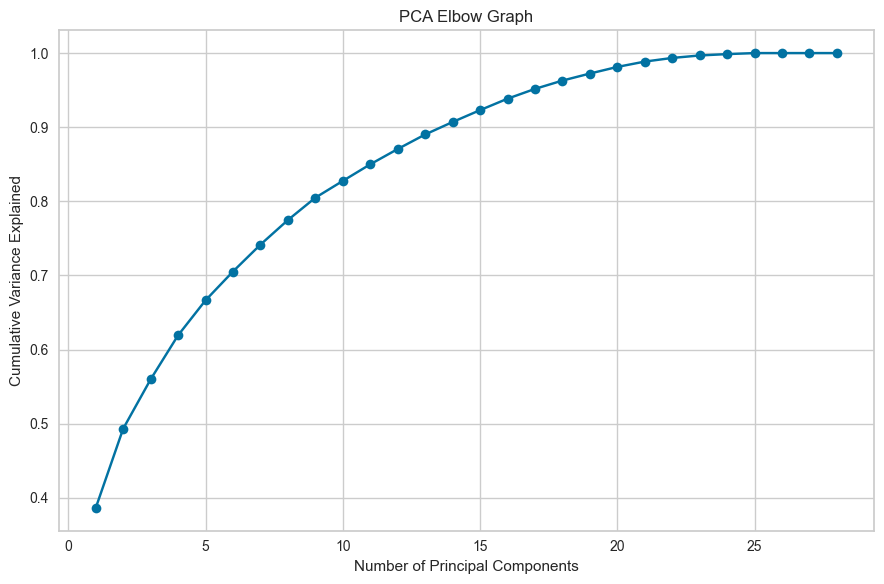

In [128]:
# Initialize PCA and run on our preprocessed dataset
pca = PCA()
pca.fit(dat_preprocessed)

# computing explained & cumulative variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plotting the elbow graph
plt.figure(figsize=(9,6))
plt.plot(range(1, len(explained_var) + 1), cumulative_var, marker = 'o')
plt.title('PCA Elbow Graph')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.tight_layout()
plt.savefig('Visuals/pca_elbow_graph.png', dpi=300, bbox_inches='tight')
plt.show()




Based on this visualization we would say that there isn't too much of an 'elbow', a clearly-defined point where we see dimininshing returns in terms of variance explained. This is typical in high-dimension data like we have, but is going to make our job a little harder.

Let's try the same process and visualization but instead of keeping all of the different product types in the dataset, let's only use `Total_Spend`. Maybe collapsing all of our different purchase types into just 'purchase amounts' will allow us to partition the variance more effectively at a low number of PCs.

In [129]:
purchase_types = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts', 'MntGoldProds']
dat_modeling_spendonly = dat_modeling.drop(columns=purchase_types) # drop the spend categories

# Re-transforming the data

# Get numeric features
numeric_features_spendonly = dat_modeling_spendonly.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Get categorical columns
categorical_features_spendonly = dat_modeling_spendonly.select_dtypes(include=['object']).columns.tolist()

# re-define preprocessor
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features_spendonly),
        ('cat', OneHotEncoder(drop=None), categorical_features_spendonly)
    ]
)

# re-transform the smaller data frame:
# Fitting the transformer to the data:
dat_spendonly_prep = preprocessor.fit_transform(dat_modeling_spendonly)


# current object is a numpy array with no column names, we want to convert it
#       to a pandas DataFrame with proper column names   

# get column names from transformer for the OHE columns:
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features_spendonly)

# Combine with numeric feature names
feature_names_spendonly = numeric_features_spendonly + list(ohe_feature_names)

dat_spendonly_prep = pd.DataFrame(dat_spendonly_prep, columns = feature_names_spendonly) # convert to DataFrame for easier handling
print(dat_spendonly_prep.head(10)) # Should see scaled values and one-hot encoded categories

print(f'Number of columns in the original preprocessed dataframe: {dat_preprocessed.shape[1]}')
print(f'Number of columns in the spend-only preprocessed dataframe: {dat_spendonly_prep.shape[1]}')
print(f'Number of columns removed: {dat_preprocessed.shape[1] - dat_spendonly_prep.shape[1]}')
print(f'Number of columns intended to remove: {len(purchase_types)}')
del(purchase_types,
    numeric_features_spendonly,
    categorical_features_spendonly,
    feature_names_spendonly,
    ohe_feature_names) # clean up workspace



     Income  Total_Spend  NumDealsPurchases  NumWebPurchases  \
0  0.287607     1.675614           0.351820         1.426669   
1 -0.260015    -0.962515          -0.167904        -1.125213   
2  0.913282     0.280226          -0.687627         1.426669   
3 -1.174638    -0.919376          -0.167904        -0.760659   
4  0.294804    -0.307131           1.391268         0.333005   
5  0.490748     0.180674          -0.167904         0.697559   
6  0.171387    -0.028385           0.871544         1.062114   
7 -0.858527    -0.726909          -0.167904        -0.031550   
8 -1.002606    -0.930991          -0.687627        -0.396104   
9 -2.149623    -0.926013          -0.687627        -1.125213   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  Offers_Accepted  \
0             2.505962          -0.555247           0.692087        -0.439024   
1            -0.570994          -1.169961          -0.133108        -0.439024   
2            -0.229110           1.288892          -

That worked, and we have 6 fewer columns which is the expected behaviour given that we were removing 6 rows of spend type data. Let's re-initialize and visualize our PCA now:

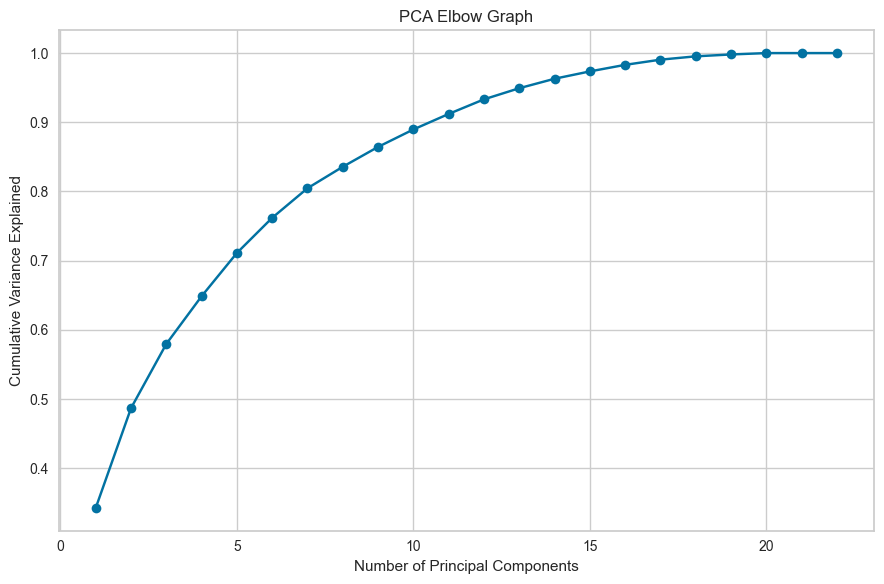

In [130]:
# re-fitting PCA
pca2 = PCA()
pca2.fit(dat_spendonly_prep)

# computing explained & cumulative variance
explained_var2 = pca2.explained_variance_ratio_
cumulative_var2 = np.cumsum(explained_var2)

# Plotting the elbow graph
plt.figure(figsize=(9,6))
plt.plot(range(1, len(explained_var2) + 1), cumulative_var2, marker = 'o')
plt.title('PCA Elbow Graph')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.tight_layout()
plt.show()


This looks identical to the last one - let's compare the cumulative variance explained at PC=3

In [131]:
print(f'Cumulative variance at PC=3 for categorized spending: {cumulative_var[2]:.4f}')
print(f'Cumulative variance at PC=3 for total spending only: {cumulative_var2[2]:.4f}')

del(explained_var, cumulative_var,
    explained_var2, cumulative_var2) # clean up workspace

del(dat_modeling_spendonly,
    dat_spendonly_prep) # clean up workspace

Cumulative variance at PC=3 for categorized spending: 0.5598
Cumulative variance at PC=3 for total spending only: 0.5796


Based on this, we would say that trimming all of the spend categories doesn't really help us in terms of partitioning the variance. Let's just do the segmentation at PC=3 using the dataset with all the spend categories (`dat_preprocessed`) and see what comes out:

In [132]:
pca_analysis = PCA(n_components=3)
pca_analysis.fit(dat_preprocessed)
PCA_data = pd.DataFrame(pca_analysis.transform(dat_preprocessed), columns = ['PC1', 'PC2', 'PC3'])
PCA_data.describe()

,PC1,PC2,PC3
count,2.207000e+03,2.207000e+03,2.207000e+03
mean,-1.287798e-17,2.639987e-16,-1.231457e-16
std,2.737110e+00,1.440074e+00,1.136352e+00
min,-5.444923e+00,-3.900675e+00,-3.401978e+00
25%,-2.441134e+00,-1.004469e+00,-7.796347e-01
50%,-8.631808e-01,-2.188979e-01,-1.470985e-02
75%,2.310940e+00,9.013270e-01,7.455975e-01
max,7.822844e+00,5.562176e+00,5.327756e+00


We now have our three principal components computed. Let's plot all of the data in 3-D projected PCA space:

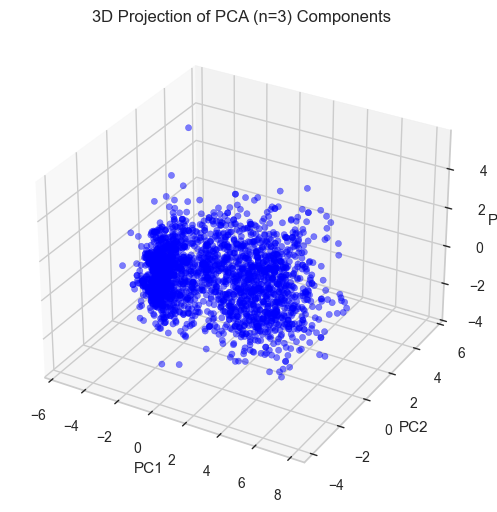

In [133]:
# 3D scatterplot of PCA results

# Putting PC components onto axis labels
x = PCA_data['PC1']
y = PCA_data['PC2']
z = PCA_data['PC3']

# building plot:
plt.figure(figsize = (6,6))
ax = plt.axes(projection = '3d')
ax.scatter(x, y, z, c='blue', marker='o', alpha=0.5)
ax.set_title("3D Projection of PCA (n=3) Components")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# clean workspace
del(ax,
    x,
    y,
    z)

So we have a pretty centralized cloud of data according to our PCA, but I do see a bit of a cleft that appears slightly left of center in the cloud. Looks like we could have some separation potentially. Let's now perform another elbow analysis, this time on the number of segments or clusters that is sensible to divide these data points into.

## Clustering

Now that our data have had their dimensionality reduced and we can visualize their spatial relationship with each other, we can observe that this projection of our data seems to indicate some potential separation or cleavage into clusters or segments. We will perform an analysis to determine the proper numver of clusters to segment our data into, and then we will perform the cluster computation. We will then 'decompose' those clusters backwards through our PCA, to identify what factors unite customers into their respective clusters.

Elbow figure to determine number of clusters to use:


<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

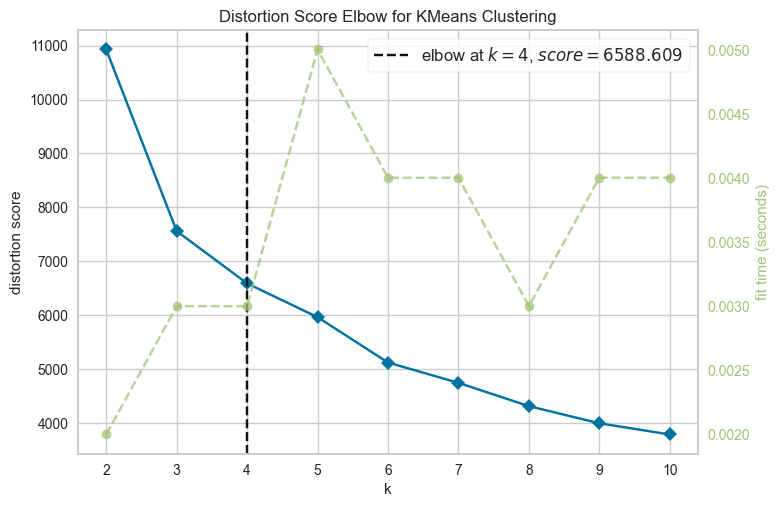

In [134]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

print('Elbow figure to determine number of clusters to use:')
Elbow = KElbowVisualizer(KMeans(), k=10)
Elbow.fit(PCA_data)
Elbow.show(outpath='Visuals/NumClusters_elbow_figure.png', dpi=300, bbox_inches='tight')


According to the fit, our optimal number of clusters to segment the customers into is 4.

Now we will apply the clustering algorithm, specifying that it is to segment the customer base into four groups:

In [135]:
from sklearn.cluster import AgglomerativeClustering

# initiate AgglomerativeClustering object
AC = AgglomerativeClustering(n_clusters=4)

# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_data)
PCA_data['Cluster'] = yhat_AC # add cluster labels to PCA data

# adding cluster labels to the original dataframe:
dat_preprocessed["Cluster"] = yhat_AC
dat_modeling = dat_modeling.copy() # create standalone copy of the original data
dat_modeling['Cluster'] = yhat_AC # add cluster labels to original data


Now that we have our cluster data, let's see how they spatially relate to each other. We'll reproduce the 3D scatterplot of the PCA data, but we'll colour it by the cluster membership to see how the four groups relate to each other in PCA space:

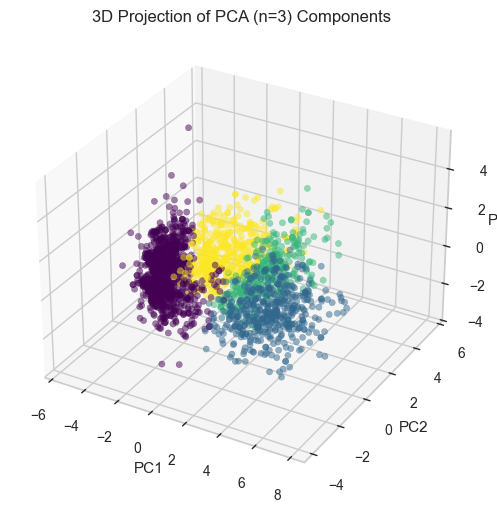

In [142]:
# Plotting PCA data, colouring by clusters

# Putting PC components onto axis labels
x = PCA_data['PC1']
y = PCA_data['PC2']
z = PCA_data['PC3']

# making actual plot:
plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
ax.scatter(x, y, z, c=PCA_data['Cluster'], marker='o', alpha=0.5, cmap='viridis')
ax.set_title("3D Projection of PCA (n=3) Components")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.savefig('Visuals/PCA_Cluster_graph.png', dpi=300, bbox_inches='tight')
plt.show()

del(x, y, z)


This is interesting now, we can see four distinct clouds of group membership within our dataset. It's time to move on to profiling, where we start 'decomposing' the clusters to get a sense of what features are instrumental in differentiating these groups.

## Profiling

Now comes the interpretation, where we diagnose what features in our dataset are influencing cluster membership.

Let's see how our different clusters allocated their spending. We won't be comparing overall spending, just the relative amount of spending on each category per cluster.



In [137]:
# get percentage spend per category:

spend_categories = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                    'MntSweetProducts', 'MntGoldProds']

# Extract keywords from category names
category_keywords = [cat.replace('Mnt', '').replace('Products', '').replace('Prods', '').lower() for cat in spend_categories]
# This will give you: ['wines', 'fruits', 'meat', 'fish', 'sweet', 'gold']

# Create mapping between original categories and keywords
cat_mapping = dict(zip(spend_categories, category_keywords))

# create new columns for each category with percentage of total spend
for cat in spend_categories:
    dat_modeling[f'{cat}_pct'] = (dat_modeling[cat] / dat_modeling['Total_Spend'])*100 

# Group by segment, compute mean and variance per category
pct_columns = [f'{cat}_pct' for cat in spend_categories]
pct_spend_data = dat_modeling.groupby('Cluster')[pct_columns].agg(['mean', 'std'])

# Rename columns with cleaner names
new_columns = [(f'{cat_mapping[cat]}_pct', stat) for cat in spend_categories for stat in ['mean', 'std']]
pct_spend_data.columns = pd.MultiIndex.from_tuples(new_columns)

pct_spend_data.head()

wines_pct            fruits_pct             meat_pct             \
              mean        std       mean       std       mean        std   
Cluster                                                                    
0        37.911635  24.075515   5.958168  6.761859  24.141100  11.117491   
1        42.877550  16.130290   4.864931  4.083313  34.103833  13.759358   
2        56.038543  18.333448   4.768185  4.614845  21.222944  10.534940   
3        58.860064  20.576439   3.009739  4.066442  19.479948  10.098529   

         fish_pct           sweet_pct             gold_pct             
             mean       std      mean       std       mean        std  
Cluster                                                                
0        8.605484  9.451929  6.070990  7.139610  17.312621  12.266092  
1        7.359249  5.378639  5.226401  5.721710   5.568036   4.911007  
2        5.980041  5.772723  4.846192  4.723954   7.144095   5.648228  
3        4.694369  6.505882  3.002402  4.091801  10.953478   9.539564

Now that we have the percentage spends for each category, let's plot them as pie charts (per cluster)

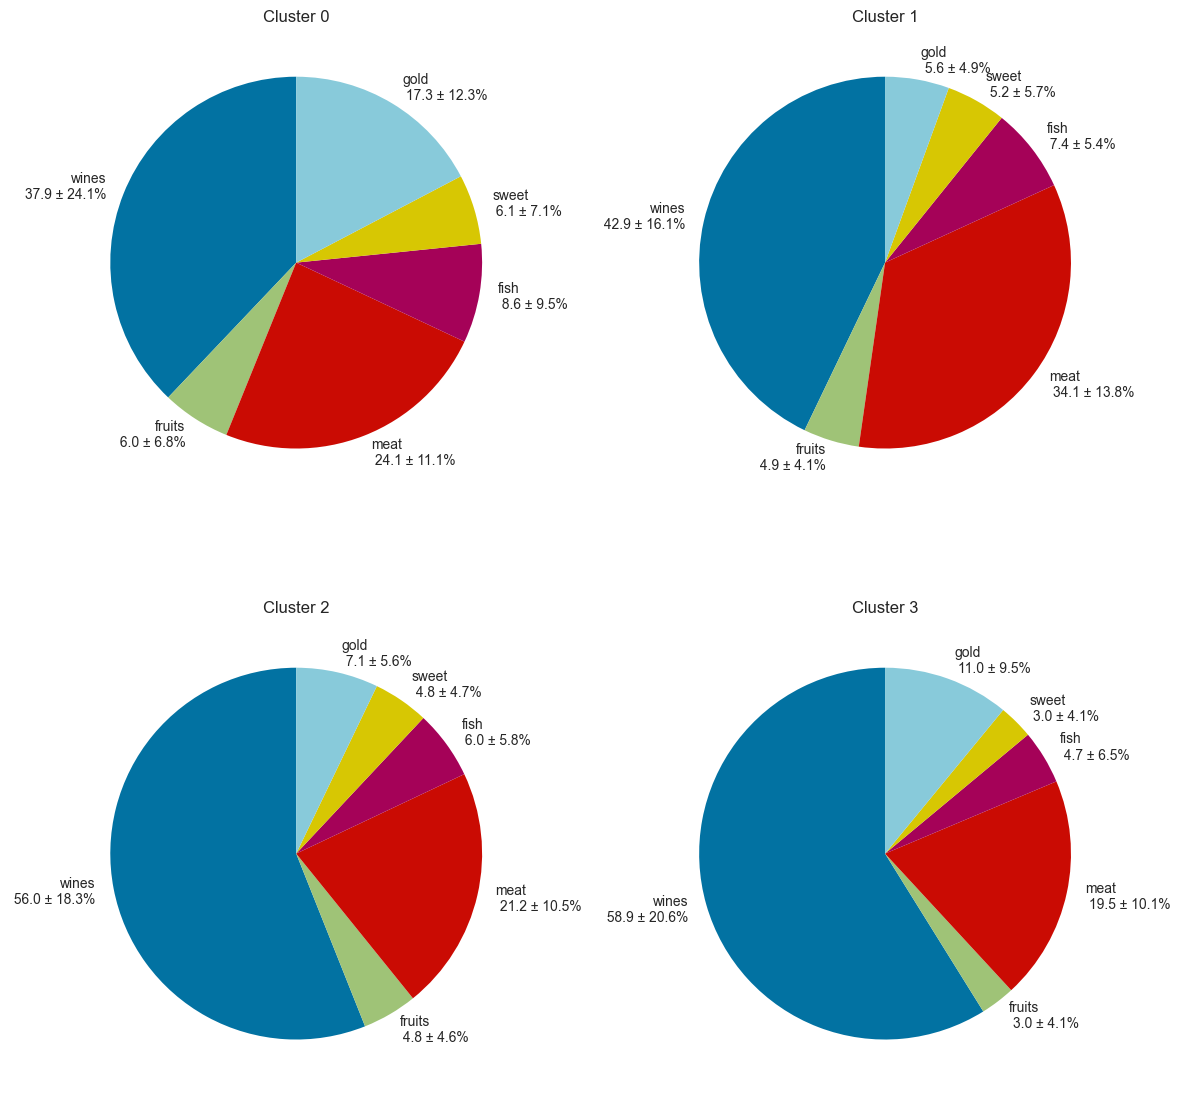

In [138]:
fig, axs = plt.subplots(2, 2, figsize = (12, 12))
axs = axs.flatten()

for i, cluster in enumerate(pct_spend_data.index):
    mean_vals = pct_spend_data.loc[cluster].xs('mean', level=1).values
    std_vals = pct_spend_data.loc[cluster].xs('std', level=1).values
    labels = [f'{cat}\n {mean_vals:.1f} ± {std_vals:.1f}%' 
          for cat, mean_vals, std_vals in zip(category_keywords, mean_vals, std_vals)]

    axs[i].pie(mean_vals, labels=labels, autopct='', startangle=90)
    axs[i].set_title(f'Cluster {cluster}')

plt.tight_layout()
plt.show()



The biggest takeaway from these pie charts I have is that it seems that wine products are the most prevalent spend for all groups. I'm not sure exactly what kind of store these data come from, but it seems they sell wine as their biggest product

The second takeaway is that the purchase profiles of all the customer segments are roughly the same, with there being a modest trend of Segment 2 having a higher relative spend on Meat products than the rest of the customer segments. 

Keep in mind that these charts are not showing that one group spent more money on a category than the other, just that a higher proportion of their relative spending was on that product type.

Let's see if there's an underlying relationship between income and the total spend, and whether this aligns with the clustering at all:

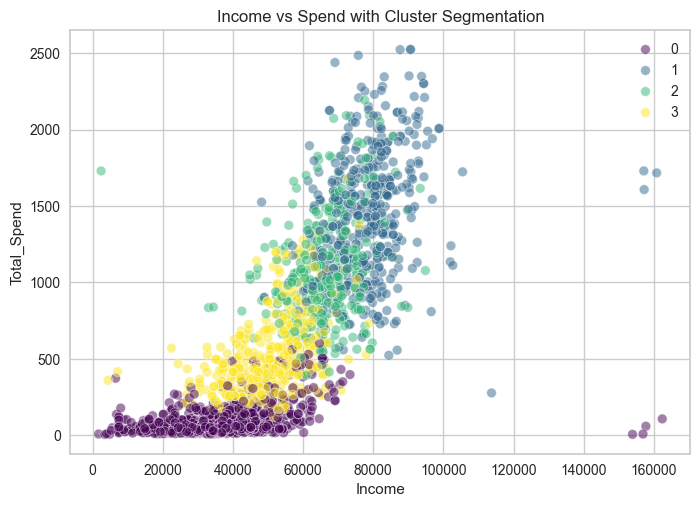

In [143]:
sns.scatterplot(data=dat_modeling, 
                x=dat_modeling['Income'],
                y = dat_modeling['Total_Spend'],
                hue=dat_modeling['Cluster'],
                palette='viridis',
                alpha=0.5)
plt.legend()
plt.title('Income vs Spend with Cluster Segmentation')
plt.savefig('Visuals/Income_Spend_Cluster_graph.png', dpi=300, bbox_inches='tight')
plt.show()

Right off the bat we would say yes, there is a relationship between your income and your spend. There seems to be a quadratic relationship between income and spend, such that your spend increases sharply with income once you exceed a certain floor of about 30,000 income.

One thing we could look for in this figure is to identify people who are lower in spend relative to their income, i.e. have more money than other people who spend similar amounts. This would be the scattering of points below and to the right of the 'main swoop' of data points. These customers could receive push notifications or some other form of 'nudge' advertisement.

As far as actual customer segmentation goes this figure gives us a good insight into the cleavage between the purple and yellow groups, i.e. `Cluster 0` and `Cluster 3`. `Cluster 0` (purple) appears to be the lowest in income, and also the lowest in spend. `Cluster 3` is similar if not a little higher in average income than `Cluster 0`, but has a notably higher spend. It's possible that we could use some targeted discount deals for `Cluster 0` to pull their average spend up towards that of `Cluster 3` while being considerate of the fact that they're a price-sensitive customer segment.


What this figure *doesn't* afford us is a clear picture of what delineates the blue from the green, i.e. `Cluster 1` versus `Cluster 2`. Both groups' income and spend are each higher than that of `Cluster 0` and `Cluster 3`, and if you squint hard enough you might say that blue (`Cluster 1`) is a little higher in income and spend, but there's still a ton of overlap. We'll need to use a different set of features to try to tease these apart more conclusively. 

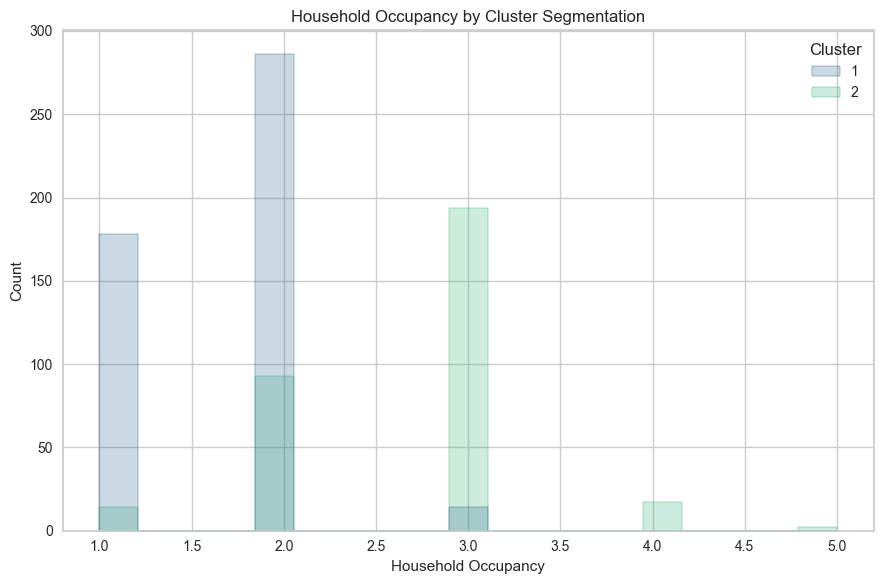

In [145]:
dat_histfilter = dat_modeling[dat_modeling['Cluster'].isin([1, 2])] # Clusters number is integer, not string
plt.figure(figsize=(9,6))
sns.histplot(data=dat_histfilter,
             x='Household_Occupancy',
             hue='Cluster',
             stat='count',
             multiple='layer',
             element='step',
             palette=['#31688e','#35b779']) # pulled the two cluster colours from the viridis palette
plt.title('Household Occupancy by Cluster Segmentation')
plt.xlabel('Household Occupancy')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



This is interesting, now we're starting to see some divergence between the two clusters. `Cluster 2` looks like they tend to have three people in the household, indicating one child or teenager. `Cluster 1` tends to not have any children in the house, as evidenced by their `Household Occupancy` having mainly values of 0 or 1. 

As these groups tended to have similarly high `Income` and `Total Spend` according to our above scatterplot, this makes me think that both of these customer segments are high-potential groups that deserve some targeted marketing. The sensible place to start would propose that customers in `Cluster 2` receive ads targeted towards households with children, and `Cluster 1` receive targeted ads that don't involve children. 

If we combine the visual results from the scatterplot and this barplot, we might say that `Cluster 1` (blue) should have more expendable income - children are expensive, and if household income is comparable between the two clusters then the households that typically aren't supporting children should have more liquidity. Let's visualize the income-per-capita of `Cluster 1` (blue) and `Cluster 2` (green). We'll predict `Cluster 1` to have higher values:

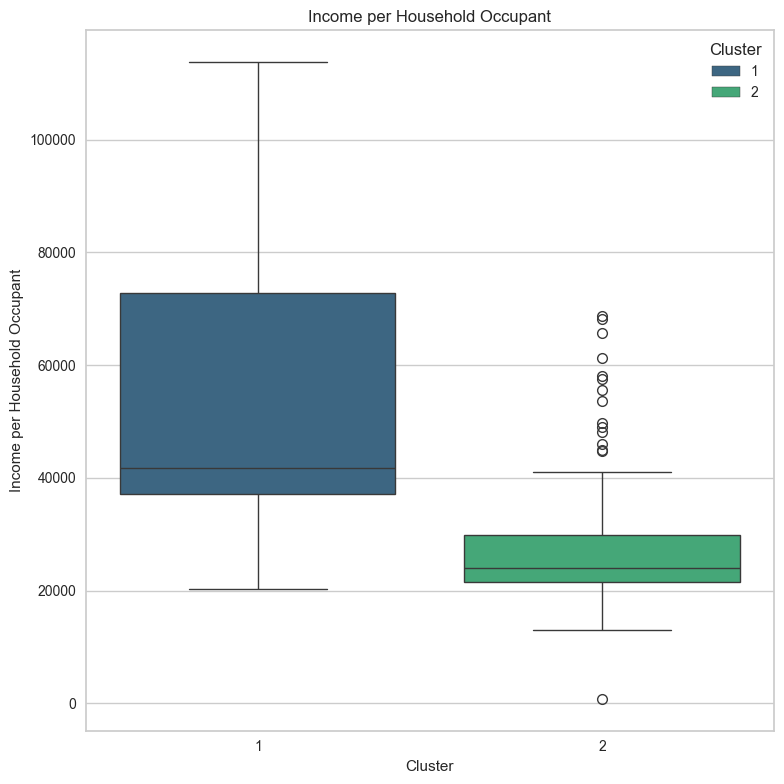

In [146]:
plt.figure( figsize=(8,8))
sns.boxplot(data=dat_histfilter,
            x=dat_histfilter['Cluster'],
            y=(dat_histfilter['Income']/dat_histfilter['Household_Occupancy']),
            hue=dat_histfilter['Cluster'],
            palette=['#31688e','#35b779']) # same two cluster colours from the histogram /viridis palette
plt.title('Income per Household Occupant')
plt.xlabel('Cluster')
plt.ylabel('Income per Household Occupant')
plt.tight_layout()
plt.savefig('Visuals/Income_per_HH_Occupant.png', dpi=300, bbox_inches='tight')
plt.show()

del(dat_histfilter)

As expected, we find `Cluster 1` to have higher income per occupant. Looking back at their proportional spend pie chart, of all the 'higher-spend' (i.e. non-`Cluster 0`) groups, `Cluster 1` actually has the lowest proportional spend on wine products. Perhaps these households have exquisite wine tastes, and we could entice them to purchase more wine if we gave them deals on some of the top-dollar, finer wine offerings?

## Wrap-up & Conclusions

In this notebook we examined a dataset on consumer purchasing history, with the goal of developing a targeted marketing strategy to increase sales. Through feature reduction and cross-validated segmentation, we found that the customer base is most neatly divided into four clusters with some key differences.

- `Cluster 0` (purple): Lowest income, lowest spend. This segment has, on average, the lowest income of all the segments. Their average spend is also the lowest, but could potentially be brought up using special discounts on some of the more affordable items.

- `Cluster 1` (blue): High income, highest spend. This customer segment has the highest income and tends not to have children, meaning their spend potential is the highest out of the customer base. This is a very high-value segment of the customer base. Interestingly they spend relatively less on wines - they may appreciate a higher selection or targeted deals on some of the upper-shelf wine options.

- `Cluster 2` (green): High income, tends to have children, less spend than other high-income groups. This group has decent income but has less spend potential due to higher household occupancy. Targeted marketing for households with children/teenagers could be helpful in bringing spend up for this customer segment.

- `Cluster 3` (yellow): Low income, moderate spend. This group has higher spend than the other low-income customer group, meaning they may be approaching their 'spend ceiling' and have lower spend potential. It's unclear whether targeted marketing would be effective in increasing the spend of this customer segment.